# Particle MCMC model for COVID-19 in Mexico

This notebook contains all of the Python code needed to use Particle Marginal Markov Chain Monte Carlo to explore the parameter space of our diffusion driven model and estimate the trajectories of the hidden states

In [4018]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
import math

In [651]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
weekly_covid_df.head()

,date,confirmed_cases,confirmed_deaths
0,2020-02-23,4.0,0.0
1,2020-03-01,23.0,0.0
2,2020-03-08,131.0,0.0
3,2020-03-15,624.0,0.0
4,2020-03-22,1152.0,6.0


In [5026]:
pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))


Total Population:  126014024
0.01% of Population:  126014


Below we create two functions to draw from our prior distributions for initial value conditions and model parameters

In [5188]:
# Initial Value Conditions Prior
def set_IVC(N, rho, nu, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = stats.uniform(0, np.round(0.001 * N).astype(int)).rvs(num_particles)   #stats.uniform(0, 100).rvs(num_particles)
    U = stats.uniform(0, np.round(E).astype(int)).rvs(num_particles)           #stats.uniform(0,5).rvs(num_particles)
    O = np.zeros(num_particles)
    S = N - E - U 
    
    beta = stats.uniform(0,1).rvs(num_particles)
    mu = stats.uniform(0,1).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(50,scale=100).rvs()
    psi_d = stats.gamma(5,scale=10).rvs()
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]
    

We begin by defining the SEUORDS model and understanding if the model will be able to produce results similar to those seen during the COVID-19 pandemic in Mexico

In [5134]:
T = 100
m = 3
h = 1/(m+1)
num_steps = int(T / h)
num_particles=100

# Initialize arrays to store results
time = np.linspace(0, T, num_steps)
X = np.zeros([8,num_particles,num_steps])
Z1 = np.zeros([num_particles, num_steps])
Z2 = np.zeros([num_particles, num_steps])

# Set initial conditions
alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d = set_param_priors()
X[:,:,0] = set_IVC(N, rho, nu, num_particles)
Z1[:,0] = np.log(X[6,:,0]+ 1e-10)
Z2[:,0] = np.log(X[7,:,0]+ 1e-10)

# Simulate the SIR model with stochastic beta using Euler-Maruyama method
for t in range(1, num_steps):
    # Sample Brownian increment
    dB1 = stats.norm(0,1).rvs(num_particles)
    dB2 = stats.norm(0,1).rvs(num_particles)
    # Update Z using Euler-Maruyama method
    Z1[:,t] = Z1[:,t-1] + sigma_b * np.sqrt(h) * dB1 
    Z2[:,t] = Z2[:,t-1] + sigma_m * np.sqrt(h) * dB2
    # Update time-varying parameter values
    X[6,:,t] = 1 / (1 + np.exp(-Z1[:, t])) # np.exp(Z1[:,t]) #update beta(t)
    X[7,:,t] = 1 / (1 + np.exp(-Z2[:, t])) # np.exp(Z2[:,t]) #update mu(t)   
    
    #Update SEUORDS model
    X[0,:,t] =  X[0,:,t-1] + (-X[6,:,t]*(X[2,:,t-1] + X[3,:,t-1])*X[0,:,t-1]/N + alpha*X[4,:,t-1])*h   # S-Susceptibles
    X[1,:,t] =  X[1,:,t-1] + (X[6,:,t]*(X[2,:,t-1] + X[3,:,t-1])*X[0,:,t-1]/N - nu*X[1,:,t-1])*h       # E-Exposed
    X[2,:,t] =  X[2,:,t-1] + (rho*nu*X[1,:,t-1] - gamma*X[2,:,t-1])*h                                  # U-Unobserved
    X[3,:,t] =  X[3,:,t-1] + ((1-rho)*nu*X[1,:,t-1] - gamma*X[3,:,t-1] - X[7,:,t]*X[3,:,t-1])*h        # O-Observed
    X[4,:,t] =  X[4,:,t-1] + (gamma*(X[2,:,t-1] + X[3,:,t-1]) - alpha*X[4,:,t-1])*h                    # R-Recovered
    X[5,:,t] =  X[5,:,t-1] + (X[7,:,t]*X[3,:,t-1])*h                                                   # D-Death

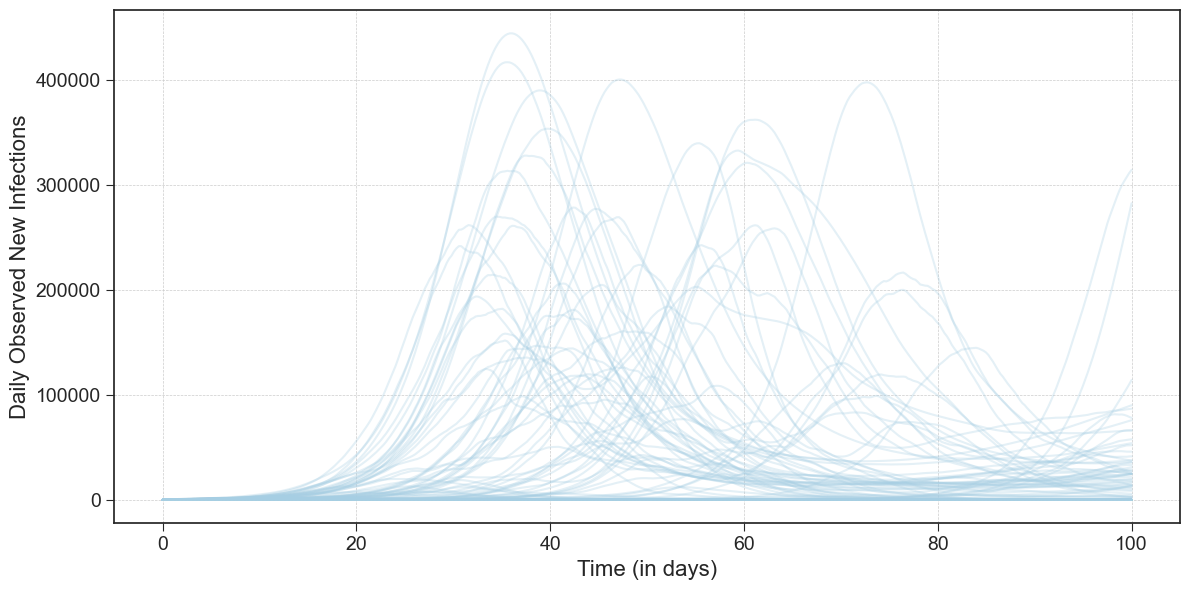

In [5135]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

for p in range(num_particles):
    plt.plot(time,X[3, p, :], color=colors[0], alpha=0.3)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in days)', fontsize=16)
plt.ylabel('Daily Observed New Infections', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

We now create a function to run our diffusion-driven epidemic model so that it can compute the hidden state transitions between observations

In [5221]:
def BM_SEUORDS(X_in, params, num_particles, m):  
    h = 1 / (m + 1) 
    num_steps = 7*(m+1) + 1 #Simulate m events per week + the initial value condition

    # Initialize arrays to store results
    X = np.zeros([X_in.shape[0], num_particles, num_steps])
    Z1 = np.zeros([num_particles, num_steps])
    Z2 = np.zeros([num_particles, num_steps])
    new_observed = np.zeros([num_particles, num_steps])
    new_deaths = np.zeros([num_particles, num_steps])

    # Set initial conditions
    alpha, rho, nu, gamma, sigma_b, sigma_m, _, _ = params
    X[:, :, 0] = X_in
    Z1[:, 0] = np.log(X_in[6, :] / (1 - X_in[6, :]))  # Logit for beta(0) np.log(X_in[6, :]) #
    Z2[:, 0] = np.log(X_in[7, :] / (1 - X_in[7, :]))  # Logit for mu(0) np.log(X_in[7, :]) # 
    new_observed = np.zeros(num_particles)
    new_deaths = np.zeros(num_particles)

    # Simulate the SIR model with stochastic beta using Euler-Maruyama method
    for t in range(1, num_steps):
        # Sample Brownian increment
        dB1 = stats.norm(0, 1).rvs(num_particles)
        dB2 = stats.norm(0, 1).rvs(num_particles)
        
        # Update Z using Euler-Maruyama method
        Z1[:, t] = Z1[:, t - 1] + sigma_b * dB1 * np.sqrt(h)
        Z2[:, t] = Z2[:, t - 1] + sigma_m * dB2 * np.sqrt(h)
        
        # Update time-varying parameter values
        X[6, :, t] = 1 / (1 + np.exp(-Z1[:, t]))  # Bounded between 0 and 1 # np.exp(Z1[:,t]) # 
        X[7, :, t] = 1 / (1 + np.exp(-Z2[:, t]))  # Bounded between 0 and 1 # np.exp(Z1[:,t]) # 
        
        # Update SEUORDS model
        X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
        X[1, :, t] = X[1, :, t - 1] + (X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
        X[2, :, t] = X[2, :, t - 1] + (rho * nu * X[1, :, t - 1] - gamma * X[2, :, t - 1]) * h                                                # U-Unobserved
        X[3, :, t] = X[3, :, t - 1] + ((1 - rho) * nu * X[1, :, t - 1] - gamma * X[3, :, t - 1] - X[7, :, t] * X[3, :, t - 1]) * h            # O-Observed
        X[4, :, t] = X[4, :, t - 1] + (gamma * (X[2, :, t - 1] + X[3, :, t - 1]) - alpha * X[4, :, t - 1]) * h                                # R-Recovered
        X[5, :, t] = X[5, :, t - 1] + (X[7, :, t] * X[3, :, t - 1]) * h                                                                       # D-Death
        
        new_observed += ((1 - rho) * nu * X[1, :, t - 1]) * h
        new_deaths += (X[7, :, t] * X[3, :, t - 1]) * h   
    
    return X, new_observed, new_deaths


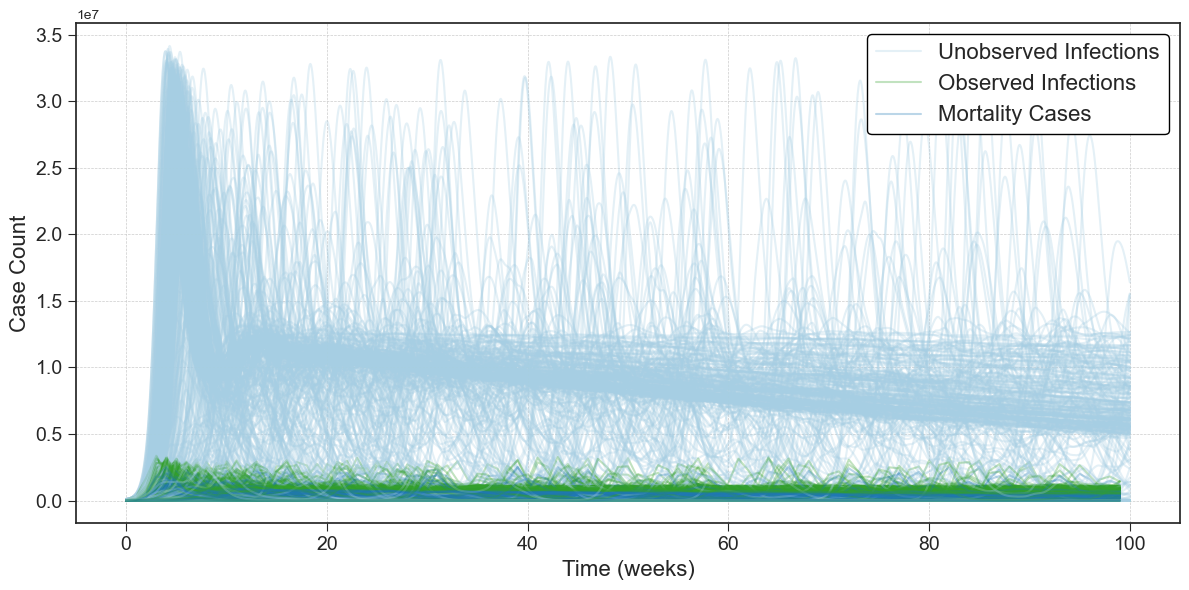

In [5138]:
T = 100
m = 2
num_particles = 500
num_steps_per_week = 7 * (m + 1) 
total_steps = T * num_steps_per_week

# Set initial conditions
params = set_param_priors()
initial_states = set_IVC(N, params[1], params[2], num_particles)
states = np.zeros([initial_states.shape[0], num_particles, total_steps + 1])  # Extra step to use last point from past week as initial value condition
states[:, :, 0] = initial_states
aggregates = np.zeros([2, num_particles, T])
start_idx = 0

# Run the model with weekly aggregation
for t in range(T):
    end_idx = start_idx + num_steps_per_week    
    weekly_results, new_observed, new_deaths = BM_SEUORDS(states[:, :, start_idx], params, num_particles, m)
    states[:, :, start_idx:end_idx + 1] = weekly_results
    aggregates[:,:,t] = np.stack((new_observed, new_deaths), axis=0)
    start_idx = end_idx 

# Plot the simulation for each particle
time = np.linspace(0, T, total_steps)  # Include the extra final point for plotting

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, states[2, 0, 1:], color=colors[0], alpha=0.3, label='Unobserved Infections')
plt.plot(np.arange(T), aggregates[0, 0, :], color=colors[3], alpha=0.3, label='Observed Infections')
plt.plot(np.arange(T), aggregates[1, 0, :], color=colors[1], alpha=0.3, label='Mortality Cases')
    
for p in range(1, num_particles):
    plt.plot(time, states[2, p, 1:], color=colors[0], alpha=0.3)
    plt.plot(np.arange(T), aggregates[0, p, :], color=colors[3], alpha=0.3)
    plt.plot(np.arange(T), aggregates[1, p, :], color=colors[1], alpha=0.3)

plt.legend(
    loc='upper right',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Having succesfully implemented the weekly version of our model we can proceed to define our likelihood functions and test-run a simple bootstrap particle filter

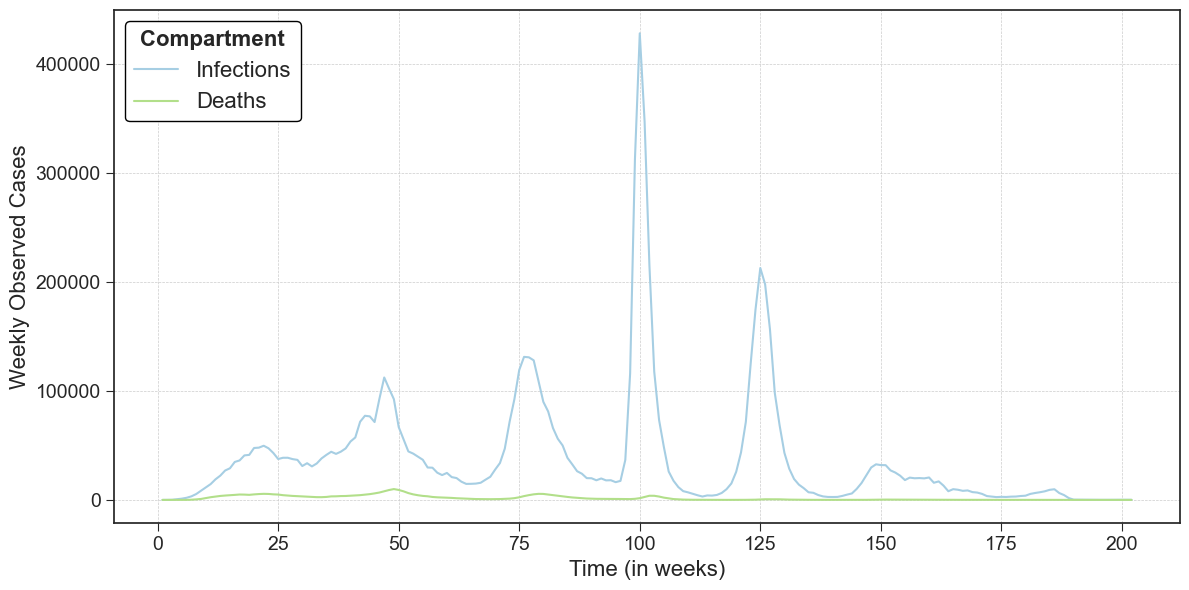

In [5227]:
# Define subset of data to run the algorithm 
T = 202
YO = weekly_covid_df['confirmed_cases'].values[:T]
YD = weekly_covid_df['confirmed_deaths'].values[:T]

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(np.arange(1, len(YO) + 1), YO, color=colors[0], label='Infections')
plt.plot(np.arange(1, len(YD) + 1), YD, color=colors[2], label='Deaths')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [4972]:
# Create NB log-likelihood function
def NB_log_likelihood(y, mu, psi):
    # Add a small positive constant to avoid numerical instability
    mu = np.maximum(mu, 1e-10)
    psi = np.maximum(psi, 1e-10)
    aux = np.maximum(mu + psi, 1e-10)
    
    return gammaln(y + psi) - gammaln(y+1) - gammaln(psi) + y * (np.log(mu) - np.log(aux)) + psi * (np.log(psi) - np.log(aux))

Following the steps of Dahlin, J. and Schön, T. B.$^1$ we work with the shifted log weights to avoid problems with numerical precision where we define
$$
v^{(i)}_t = \log(w^{(i)}_t) - v_{max}
$$
with $v_{max} = \max_{i} \log(w^{(i)}_t)$ and $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$. 

With this in mind, the normalized weights can be calculated using 
$$ 
\bar{w}^{(i)}_t = \frac{w^{(i)}_t}{\sum_i w^{(i)}_t} = \frac{e^{v_{max}} e^{v^{(i)}_t}}{\sum_i e^{v_{max}} e^{v^{(i)}_t}} = \frac{e^{v^{(i)}_t}}{\sum_i e^{v^{(i)}_t}} = \tilde{v}^{(i)}_t.
$$

Additionally, instead of calculating the marginal likelihood
$$
\hat{p}(y_{1:t}) = \hat{p}(y_{1:t-1}) \hat{p}(y_t | y_{1:t-1}) = \hat{p}(y_{1:t-1}) \left( \frac{1}{N} \sum_i w^{(i)}_t \right)
$$
we can approximate the marginal log-likelihood using $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$ with
\begin{align*}
\log (\hat{p}(y_{1:t})) & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i w^{(i)}_t \right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i e^{v_{max}} e^{v^{(i)}_t}\right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log(v_{max}) + \log\left( \sum_i e^{v^{(i)}_t} \right) - \log(N)
\end{align*}

$1$: Dahlin, J., & Schön, T. B. (2019). *Getting started with particle Metropolis-Hastings for inference in nonlinear dynamical models*. Journal of Statistical Software, 88, 1–41.


In [5245]:
m = 4
num_particles = 1000
num_steps_per_week = 7 * (m + 1) 
total_steps = T * num_steps_per_week

# Set initial conditions for epidemic model
params = set_param_priors()
initial_conditions = set_IVC(N, params[1], params[2], num_particles)
start_idx = 0

# Initialize PF variables
state_estimates = np.zeros([initial_conditions.shape[0], total_steps + 1])
particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
resampled_partices = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
weekly_aggregates = np.zeros([2, num_particles, T+1])
weights = np.zeros([num_particles, total_steps + 1])
norm_weights = np.zeros([num_particles, total_steps + 1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)

# Define values at time t=0
particles[:, :, 0] = initial_conditions
resampled_partices[:,:,0] = initial_conditions
weights[:,0] = 1 / num_particles
norm_weights[:,0] = 1 / num_particles
ancestry_matrix[:,0] = np.arange(num_particles)
ESS[0] = num_particles

loglikelihood = 0
state_estimates[:,0] = np.mean(particles[:,:,0], axis=1)

for t in range(1,T+1):
    
    # Propagate particles to next week
    weekly_results, new_observed, new_deaths = BM_SEUORDS(particles[:, ancestry_matrix[:,t-1].astype(int), start_idx], params, num_particles, m)
    weekly_aggregates[:,:,t] = np.stack((new_observed, new_deaths), axis=0)
    end_idx = start_idx + num_steps_per_week    
    
    particles[:, :, start_idx:end_idx + 1] = weekly_results
    start_idx = end_idx 

    # Update particle weights and resample
    incremental_weights = NB_log_likelihood(YO[t-1], weekly_aggregates[0,:,t], params[6]) + NB_log_likelihood(YD[t-1], weekly_aggregates[1,:,t], params[7]) 
    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    state_estimates[:,t] = np.mean(particles[:,:,t], axis=1)
    
    # Systematic resampling
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
    
    #ancestry_matrix[:,:t-1] = ancestry_matrix[resample_indices,:t-1] #resample particle lineage
    ancestry_matrix[:,t] = resample_indices #store ancestry indexes 

print(loglikelihood)

-3462.6259470310933


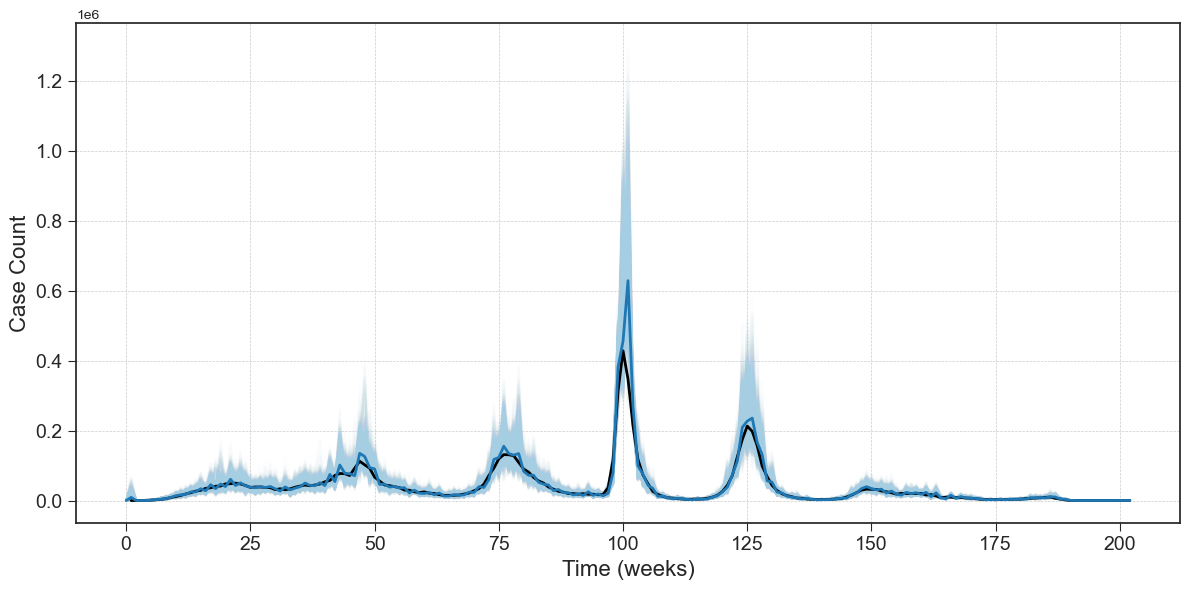

In [5249]:
# Plot the weekly recorded cases incidence
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')
for p in range(0, num_particles):
    plt.plot(weekly_aggregates[0,p,:], color=colors[0], alpha=0.025)
    
plt.plot(np.arange(1, len(YO) + 1), YO, color='black', linewidth=2)
plt.plot(np.median(weekly_aggregates[0,:,:], axis=0), color=colors[1], linewidth=2)
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

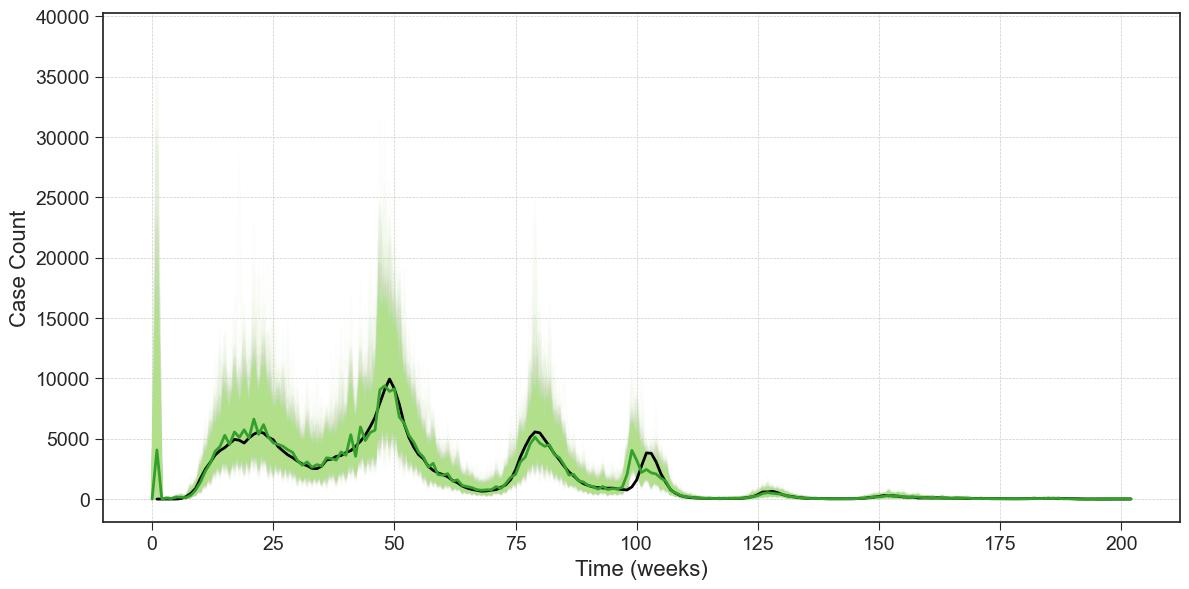

In [5251]:
# Plot the Weekle death incidence
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')
for p in range(0, num_particles):
    plt.plot(weekly_aggregates[1,p,:], color=colors[2], alpha=0.025)
    
plt.plot(np.arange(1, len(YO) + 1), YD, color='black', linewidth=2)
plt.plot(np.median(weekly_aggregates[1,:,:], axis=0), color=colors[3], linewidth=2)
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Case Count', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()